# Imports

In [ ]:
from notebooks import *

INFO     [19:48:47.252] [38118] 154 logging_/<module>: {logging_yaml: None}

In [ ]:
# Import bqq() / %%bqq
#   - HACK Add pydatalab
#       - Use local fork to avoid having to deal with upgrades and porting old patches
sys.path.insert(1, os.path.expanduser('~/hack/pydatalab'))
from potoo.bqq import *
%load_ext potoo.sql_magic

The potoo.sql_magic extension is already loaded. To reload it, use:

  %reload_ext

potoo.sql_magic

In [ ]:
def var_checkpoint(var_name, env, pkl_path='/tmp/var_checkpoint/%s.pkl'):
    pkl_path = pkl_path % var_name
    if var_name in env:
        print('dump: %(var_name)s -> %(pkl_path)s' % locals())
        joblib.dump(env[var_name], ensure_parent_dir(pkl_path))
    else:
        print('load: %(var_name)s <- %(pkl_path)s' % locals())
        env[var_name] = joblib.load(pkl_path)

def sort_like(xs, ys):
    ys = list(ys)
    return sorted(xs, key=lambda x: ys.index(x) if x in ys else -1)

def sort_like_com_name(xs):
    return sort_like(xs, metadata.species.df.com_name.dtype.categories)

def sort_like_species_group(xs):
    return sort_like(xs, metadata.species.df.species_group.dtype.categories)

species_group_for_com_name = (metadata.species.df
    [['com_name', 'species_group']]
    .set_index('com_name')
    .to_dict()['species_group']
)

# bq utils

In [ ]:
# TODO Why do these defs prevent bq cache hits?
bqq = BQQ(defs='''

    create temp function mul_trunc(x int64, y int64) as (
        div(x, y) * y
    );

    # Mimic ebird_week in ebird_priors.py
    # 'Week' like ebird barchart weeks: 4 weeks per month, where the 4th week includes all days past 28
    #   - 0-indexed (0–47)
    create temp function ebird_week(d date) as (
        (extract(month from d) - 1) * 4 +
        least(div(extract(day from d) - 1, 7), 3)
    );

    # Mimic ebird_bar_width in ebird_priors.py
    # https://help.ebird.org/customer/portal/articles/1010553-understanding-the-ebird-bar-charts
    # https://help.ebird.org/customer/en/portal/articles/1210247-what-is-frequency-
    create temp function ebird_bar_width(p float64) as (
        case
            when p >= .600 then 9
            when p >= .400 then 8
            when p >= .300 then 7
            when p >= .200 then 6
            when p >= .100 then 5
            when p >= .050 then 4
            when p >= .010 then 3
            when p >= .003 then 2
            when p >= .000 then 1
        end
    );

    # Mimic ebird_bar_str in ebird_priors.py
    create temp function ebird_bar_str(p float64) as (
        concat(
            repeat('■', ebird_bar_width(p)),
            repeat('—', 9 - ebird_bar_width(p))
        )
    );

    create temp function _geohash_char_at_bits(c string, char_bits int64) as (
        # https://en.wikipedia.org/wiki/Geohash
        substr(
            case char_bits
                when 0 then '0123456789bcdefghjkmnpqrstuvwxyz'
                when 1 then '0000000000000000hhhhhhhhhhhhhhhh'
                when 2 then '0000000088888888hhhhhhhhssssssss'
                when 3 then '000044448888ddddhhhhnnnnsssswwww'
                when 4 then '0022446688bbddffhhkknnqqssuuwwyy'
            end,
            strpos('0123456789bcdefghjkmnpqrstuvwxyz', c),
            1
        )
    );

    create temp function geohash_at_bits(geo geography, bits int64) as (
        case
            # Guard against bits > 100 since st_geohash returns max 20 chars (* 5 = 100 bits)
            when not (0 < bits and bits <= 100) then error(format('Expected 0 < bits[%d] <= 100', bits))
            else concat(
                # All but last char in geohash ((bits - 1) // 5)
                #   - Manually substr(st_geohash(geo, 20), ...) to avoid st_geohash(geo, 0), which returns all 20 bits
                substr(st_geohash(geo, 20), 1, div(bits - 1, 5)),
                # Last char in geohash, truncated to remaining bits (% 5)
                _geohash_char_at_bits(
                    substr(st_geohash(geo, div(bits - 1, 5) + 1), -1, 1),
                    mod(bits, 5)
                )
            )
        end
    );

''')

In [ ]:
# Inspect defs
#   - TODO Add some asserts
(bqq
    .query(
        from_='ebird.obs_sample_001',
        where='''true
            and state_code = 'US-CA'
            and category in ('species', 'issf', 'form', 'intergrade')
        ''',
        select='''
            common_name,
            ebird_week(observation_date) as observation_week,
            locality_id,
            locality,
            st_geohash(st_geogpoint(longitude, latitude))           as n_all,
            st_geohash(st_geogpoint(longitude, latitude), 20)       as n_20,
            geohash_at_bits(st_geogpoint(longitude, latitude), 100) as b_100,
            geohash_at_bits(st_geogpoint(longitude, latitude), 99)  as b_99,
            geohash_at_bits(st_geogpoint(longitude, latitude), 98)  as b_98,
            geohash_at_bits(st_geogpoint(longitude, latitude), 97)  as b_97,
            geohash_at_bits(st_geogpoint(longitude, latitude), 96)  as b_96,
            st_geohash(st_geogpoint(longitude, latitude), 19)       as n_19,
            geohash_at_bits(st_geogpoint(longitude, latitude), 95)  as b_95,
            geohash_at_bits(st_geogpoint(longitude, latitude), 94)  as b_94,
            geohash_at_bits(st_geogpoint(longitude, latitude), 93)  as b_93,
            geohash_at_bits(st_geogpoint(longitude, latitude), 92)  as b_92,
            geohash_at_bits(st_geogpoint(longitude, latitude), 91)  as b_91,
            st_geohash(st_geogpoint(longitude, latitude), 2)        as n_2,
            geohash_at_bits(st_geogpoint(longitude, latitude), 10)  as b_10,
            geohash_at_bits(st_geogpoint(longitude, latitude), 9)   as b_9,
            geohash_at_bits(st_geogpoint(longitude, latitude), 8)   as b_8,
            geohash_at_bits(st_geogpoint(longitude, latitude), 7)   as b_7,
            geohash_at_bits(st_geogpoint(longitude, latitude), 6)   as b_6,
            st_geohash(st_geogpoint(longitude, latitude), 1)        as n_1,
            geohash_at_bits(st_geogpoint(longitude, latitude), 5)   as b_5,
            geohash_at_bits(st_geogpoint(longitude, latitude), 4)   as b_4,
            geohash_at_bits(st_geogpoint(longitude, latitude), 3)   as b_3,
            geohash_at_bits(st_geogpoint(longitude, latitude), 2)   as b_2,
            geohash_at_bits(st_geogpoint(longitude, latitude), 1)   as b_1,
        ''',
        order_by='rand()',
        limit=20,
    )
    .df()
    .T
)

INFO     [19:48:48.297] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:48:54.068] [38118] 368 potoo.bqq/_bqq: [6s] cost[$0.0002, 48.6 MB] rows[20] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_SZtNQoiYl7BFRskselso5KxPsTkW&page=queryresults]

INFO     [19:48:54.093] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:48:54.644] [38118] 418 potoo.bqq/_bqq: [1s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
common_name,California Towhee,Chestnut-backed Chickadee,Chestnut-backed Chickadee,House Finch,American Crow,Sharp-shinned Hawk,Least Tern,Western Gull,California Scrub-Jay,Turkey Vulture,Northern Shoveler,Lesser Goldfinch,Gadwall,Bushtit,Orange-crowned Warbler,Allen's Hummingbird,Great Egret,Ring-billed Gull,Dunlin,Turkey Vulture
observation_week,8,39,40,10,43,46,28,0,47,26,4,14,4,22,40,39,44,42,11,0
locality_id,L505069,L624843,L370768,L677500,L235486,L363848,L6154968,L332226,L5054359,L353751,L152122,L3913598,L495595,L264648,L3513569,L1009720,L682050,L5096432,L509134,L1013396
locality,Sedgwick Reserve UCSB,Half Moon Bay WTP,Golden Gate Park--North Lake,Crystal Springs Reservoir,Tecolote Canyon Natural Park,UCSC- Lower Campus (general area),Elsie Roemer Bird Sanctuary,Seal Beach NWR (restricted access),US-CA-Los Angeles-4526 Griffin Ave - 34.0944x-118.2023,Mayflower County Park,Palo Alto Baylands,Cheryl Lish (Hummingbird) Home,Diaz Lake,Neary Lagoon,Irvine yard,Wolff Rd. tamarisks,Lake Sherwood,US-CA-Nice-3756 Lakeshore Blvd - 39.1211x-122.8423,Elsie Roemer Bird Sanctuary,Black Butte Lake--Buckhorn Rec Area
n_all,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfcg,9q8yu7u47czvpym70fmp,9q8vru6j5yrfpeukfx6q,9mudmq98fmghfnkezk56,9q94qsbpk00n01mthhug,9q9nf0yjsbxfnye6pene,9mupcp4zrwt2ghsq2z0u,9q5cynxwqey9qwfq4tey,9myx99w7zwe19v2w820p,9q9jj7nr2ng502j0sd74,9q4rbtz7fm9ktvv355fx,9qkpcxfqbp0pbth4qxkn,9q94r0unz8hvzqzj67u2,9mupxwqt9v89f4wrvbgn,9q5692zq8cpfp8eujnub,9q56nyy09gzbx4hqk83x,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczmz,9r0frrqwv401b6hq81wg
n_20,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfcg,9q8yu7u47czvpym70fmp,9q8vru6j5yrfpeukfx6q,9mudmq98fmghfnkezk56,9q94qsbpk00n01mthhug,9q9nf0yjsbxfnye6pene,9mupcp4zrwt2ghsq2z0u,9q5cynxwqey9qwfq4tey,9myx99w7zwe19v2w820p,9q9jj7nr2ng502j0sd74,9q4rbtz7fm9ktvv355fx,9qkpcxfqbp0pbth4qxkn,9q94r0unz8hvzqzj67u2,9mupxwqt9v89f4wrvbgn,9q5692zq8cpfp8eujnub,9q56nyy09gzbx4hqk83x,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczmz,9r0frrqwv401b6hq81wg
b_100,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfcg,9q8yu7u47czvpym70fmp,9q8vru6j5yrfpeukfx6q,9mudmq98fmghfnkezk56,9q94qsbpk00n01mthhug,9q9nf0yjsbxfnye6pene,9mupcp4zrwt2ghsq2z0u,9q5cynxwqey9qwfq4tey,9myx99w7zwe19v2w820p,9q9jj7nr2ng502j0sd74,9q4rbtz7fm9ktvv355fx,9qkpcxfqbp0pbth4qxkn,9q94r0unz8hvzqzj67u2,9mupxwqt9v89f4wrvbgn,9q5692zq8cpfp8eujnub,9q56nyy09gzbx4hqk83x,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczmz,9r0frrqwv401b6hq81wg
b_99,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfcf,9q8yu7u47czvpym70fmn,9q8vru6j5yrfpeukfx6q,9mudmq98fmghfnkezk56,9q94qsbpk00n01mthhuf,9q9nf0yjsbxfnye6pend,9mupcp4zrwt2ghsq2z0u,9q5cynxwqey9qwfq4tey,9myx99w7zwe19v2w820n,9q9jj7nr2ng502j0sd74,9q4rbtz7fm9ktvv355fw,9qkpcxfqbp0pbth4qxkn,9q94r0unz8hvzqzj67u2,9mupxwqt9v89f4wrvbgn,9q5692zq8cpfp8eujnub,9q56nyy09gzbx4hqk83w,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczmy,9r0frrqwv401b6hq81wf
b_98,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfcd,9q8yu7u47czvpym70fmn,9q8vru6j5yrfpeukfx6n,9mudmq98fmghfnkezk54,9q94qsbpk00n01mthhud,9q9nf0yjsbxfnye6pend,9mupcp4zrwt2ghsq2z0s,9q5cynxwqey9qwfq4tew,9myx99w7zwe19v2w820n,9q9jj7nr2ng502j0sd74,9q4rbtz7fm9ktvv355fw,9qkpcxfqbp0pbth4qxkn,9q94r0unz8hvzqzj67u0,9mupxwqt9v89f4wrvbgn,9q5692zq8cpfp8eujnu8,9q56nyy09gzbx4hqk83w,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczmw,9r0frrqwv401b6hq81wd
b_97,9q4tk7u9pfzyrf050wqh,9q8vjtxr6gxur6v4jfc8,9q8yu7u47czvpym70fmh,9q8vru6j5yrfpeukfx6h,9mudmq98fmghfnkezk50,9q94qsbpk00n01mthhu8,9q9nf0yjsbxfnye6pen8,9mupcp4zrwt2ghsq2z0s,9q5cynxwqey9qwfq4tes,9myx99w7zwe19v2w820h,9q9jj7nr2ng502j0sd70,9q4rbtz7fm9ktvv355fs,9qkpcxfqbp0pbth4qxkh,9q94r0unz8hvzqzj67u0,9mupxwqt9v89f4wrvbgh,9q5692zq8cpfp8eujnu8,9q56nyy09gzbx4hqk83s,9qbws9ucjvc9urnqtcds,9q9nf0whv6rbpgegczms,9r0frrqwv401b6hq81w8


In [ ]:
# WARNING $0.07
# For join with metadata.ebird.shorthand, ensure no/few unmapped species
#   - cf. model.metadata.com_names_to_species
(bqq.no_defs
    .with_(
        ebird_species=lambda bqq: (bqq
            .query(
                # from_='ebird.obs_sample_001',  # XXX Dev
                from_='ebird.obs_all_expensive',
                where='''true
                    and category in ('species', 'issf', 'form', 'intergrade')
                    and country_code = 'US'
                ''',
                select='''distinct
                    common_name,
                    category
                ''',
            )
        ),
    )
    .query(
        from_='''
            ebird_species e
            left join metadata.species s on (e.common_name = s.com_name)
        ''',
        where='''true
            and (common_name is null or com_name is null)
        ''',
        select='''
            category,
            common_name,
            com_name,
            shorthand,
        ''',
    )
    .df()
    .pipe(df_inspect, lambda df: (df.shape,))
    .fillna('')
)

INFO     [19:49:14.174] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:49:32.125] [38118] 368 potoo.bqq/_bqq: [18s] cost[$0.0705, 15.5 GB] rows[2] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_SM7jncaalIAnjkm0eQI2oq_XRpPl&page=queryresults]

INFO     [19:49:32.138] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:49:32.381] [38118] 418 potoo.bqq/_bqq: [0s]

(2, 4)

,category,common_name,com_name,shorthand
0,form,Leach's/Townsend's Storm-Petrel (dark-rumped),,
1,form,Leach's/Townsend's Storm-Petrel (white-rumped),,


# Create tables to map geohash to its expands, for smoothing
- Vary precision to do the kind of smoothing we want: prec=n -> prec=bits+2 -> expands (x9) -> prec=bits (x4)
- Q: Do we need all geohashes, or should we restrict just to US ones? (from join with ebird table)
    - A: Going with all geohashes

In [ ]:
# Which tables have we already created?
!bq ls geoh

                    tableId                     Type    Labels   Time Partitioning  
 --------------------------------------------- ------- -------- ------------------- 
  all_geohashes_with_expand_precision_bits_1    TABLE                               
  all_geohashes_with_expand_precision_bits_13   TABLE                               
  all_geohashes_with_expand_precision_bits_15   TABLE                               
  all_geohashes_with_expand_precision_bits_17   TABLE                               
  all_geohashes_with_expand_precision_bits_19   TABLE                               
  all_geohashes_with_expand_precision_bits_21   TABLE                               
  all_geohashes_with_expand_precision_bits_23   TABLE                               
  all_geohashes_with_expand_precision_bits_3    TABLE                               
  all_geohashes_with_expand_precision_bits_5    TABLE                               


In [ ]:
# precision_bits = 1   # len[   2] time[   0s +    7s] bq[   24b,     4 rows]
# precision_bits = 3   # len[   8] time[   0s +    7s] bq[  288b,    48 rows]
# precision_bits = 5   # len[  32] time[   0s +    7s] bq[ 1.4kb,   240 rows]
precision_bits = 13  # len[  8k] time[   0s +    8s] bq[ 713kb,   73k rows]
# precision_bits = 15  # len[ 32k] time[   2s +   11s] bq[ 2.8mb,  293k rows]
# precision_bits = 17  # len[128k] time[  10s +   24s] bq[13.5mb,  1.8m rows]
# precision_bits = 19  # len[512k] time[  50s +   68s] bq[  54mb,  4.7m rows]
# precision_bits = 21  # len[  2m] time[ 262s +  287s] bq[ 252mb, 18.8m rows]
# precision_bits = 23  # len[  8m] time[1656s + 1013s] bq[ 1.0gb, 75.4m rows]
table = f'geoh.all_geohashes_with_expand_precision_bits_{precision_bits}'
xs = geoh.all_geohashes_with_expand(precision_bits)
# Create table
df = (
    pd.DataFrame(
        columns=['x', 'y'],
        data=list(tqdm(total=len(xs), iterable=(
            (k, v)
            for k, vs in xs.items()
            for v in vs
        ))),
    )
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:10])
    .pipe(df_to_bq, table=table, overwrite=True)
)
# Inspect table
(bqq.no_defs
    .query(
        from_=table,
        select='count(*) as n, count(distinct x) as n_distinct',
    )
    .df(show_query=True)
    .T
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:00<00:00, 14256.22it/s]

72960it [00:00, 2104160.10it/s]                                                                                                          

(72960, 2)

,x,y
0,000,000
1,000,004
2,000,008
3,000,00d
4,000,pbn
5,000,pbw
6,004,000
7,004,004
8,004,008
9,004,00d


INFO     [19:49:49.991] [38118] 476 potoo.bqq/df_to_bq: Inferred schema[{'x': 'string', 'y': 'string'}] from dtypes[{'x': dtype('O'), 'y': dtype('O')}]

INFO     [19:49:50.000] [38118] 479 potoo.bqq/df_to_bq: Creating table[geoh.all_geohashes_with_expand_precision_bits_13] with schema[{'x': 'string', 'y': 'string'}]...

INFO     [19:49:51.041] [38118] 493 potoo.bqq/df_to_bq: Uploading df to gs[gs://potoo-bqq/load/v0/2019-09-03T02-49-51-041632.csv]...

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


INFO     [19:49:53.199] [38118] 508 potoo.bqq/df_to_bq: Loading table[geoh.all_geohashes_with_expand_precision_bits_13] from gs[gs://potoo-bqq/load/v0/2019-09-03T02-49-51-041632.csv]...

INFO     [19:49:59.239] [38118] 524 potoo.bqq/df_to_bq: [9s] rows[72960] size[712.5 KiB]

INFO     [19:49:59.252] [38118] 355 potoo.bqq/_bqq: Running query... [
    select count(*) as n, count(distinct x) as n_distinct
    from geoh.all_geohashes_with_expand_precision_bits_13
]

INFO     [19:50:00.993] [38118] 368 potoo.bqq/_bqq: [2s] cost[$0.0000, 364.8 kB] rows[1] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_EP8mc9FYlRYkRXeFUIhrUUWol05_&page=queryresults]

INFO     [19:50:01.006] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:50:01.474] [38118] 418 potoo.bqq/_bqq: [0s]

,0
n,72960
n_distinct,8192


# Basic stats

In [ ]:
# WARNING $0.09
# How many obs, checklists, hotspots, species?
(bqq.no_defs
    .query(
        # from_='ebird.obs_sample_001',  # XXX Dev
        from_='ebird.obs_all_expensive',
        select='''
            count(*)                                                                as n,
            count(distinct format("%s/%s", sampling_event_identifier, common_name)) as roughly_n, # Verify that (checklist, species) are unique
            count(distinct sampling_event_identifier)                               as n_checklists,
            count(distinct locality_id)                                             as n_hotspots,
            count(distinct common_name)                                             as n_species,
        ''',
    )
    .df()
    .T
)

INFO     [19:50:02.637] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:50:03.925] [38118] 368 potoo.bqq/_bqq: [1s] cost[cached] rows[1] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_176E2UQdOT7wEZqMmnfi_hrXx-Ae&page=queryresults]

INFO     [19:50:03.936] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:50:04.465] [38118] 418 potoo.bqq/_bqq: [1s]

,0
n,508111445
roughly_n,507471699
n_checklists,36812628
n_hotspots,5710382
n_species,11726


In [ ]:
# WARNING $0.01
# How many obs by country?
#   - 362m/508m in US
#   -  50m/508m is next biggest country
(bqq.no_defs
    .query(
        # from_='ebird.obs_sample_001',  # XXX Dev
        from_='ebird.obs_all_expensive',
        group_by='1',
        select='''
            country_code,
            count(*) n_obs,
            count(*) / sum(count(*)) over () p_obs,
            sum(count(*)) over () total_obs,
        ''',
        order_by='2 desc',
        limit=10,
    )
    .df()
)

INFO     [19:50:14.315] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:50:15.646] [38118] 368 potoo.bqq/_bqq: [1s] cost[cached] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_HE103W3qw3tCOSdAhmL_hhRja4v0&page=queryresults]

INFO     [19:50:15.658] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:50:16.196] [38118] 418 potoo.bqq/_bqq: [1s]

,country_code,n_obs,p_obs,total_obs
0,US,362480201,0.713,508111445
1,CA,50217998,0.099,508111445
2,AU,14418719,0.028,508111445
3,IN,10349707,0.020,508111445
4,MX,6293521,0.012,508111445
5,CR,4931603,0.010,508111445
6,GB,4471881,0.009,508111445
7,ES,3897594,0.008,508111445
8,PT,3345458,0.007,508111445
9,BR,3210548,0.006,508111445


In [ ]:
# WARNING $0.04, time[46s]
# How many unique geohashes, at various precisions?
#   - See ebird_priors.py for bits:mi mapping (EbirdPriors._loc_binwidths)
(bqq
    .query(
        # from_='ebird.obs_sample_001',  # XXX Dev
        from_='ebird.obs_all_expensive',
        select='''
            count(*)                                                               as n,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 31)) as n_geohash_0_4mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 29)) as n_geohash_0_8mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 27)) as n_geohash_1_5mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 25)) as n_geohash_3mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 23)) as n_geohash_6mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 21)) as n_geohash_12mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 19)) as n_geohash_24mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 17)) as n_geohash_48mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 15)) as n_geohash_97mi,
            count(distinct geohash_at_bits(st_geogpoint(longitude, latitude), 13)) as n_geohash_194mi,
        ''',
    )
    .df()
    .T
)

INFO     [19:50:25.629] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:51:00.485] [38118] 368 potoo.bqq/_bqq: [35s] cost[$0.0370, 8.1 GB] rows[1] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_CQxHE2Cn68j8FL3pZnCIoZppOQVW&page=queryresults]

INFO     [19:51:00.500] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:51:00.816] [38118] 418 potoo.bqq/_bqq: [0s]

,0
n,508111445
n_geohash_0_4mi,2946715
n_geohash_0_8mi,2041719
n_geohash_1_5mi,1239658
n_geohash_3mi,666661
n_geohash_6mi,324744
n_geohash_12mi,146243
n_geohash_24mi,62410
n_geohash_48mi,25512
n_geohash_97mi,10065


# Priors: Start with something simple

In [ ]:
# Inspect available tables
!bq ls metadata
!bq ls xc
!bq ls ebird

  tableId   Type    Labels   Time Partitioning  
 --------- ------- -------- ------------------- 
  species   TABLE                               


           tableId             Type    Labels   Time Partitioning  
 ---------------------------- ------- -------- ------------------- 
  _rec_count_per_species_csv   TABLE                               
  n_recs_per_species           VIEW                                


            tableId              Type    Labels   Time Partitioning  
 ------------------------------ ------- -------- ------------------- 
  _ebd_relMay_2018_txt           TABLE                               
  _ebd_relMay_2018_txt_001       TABLE                               
  _ebd_relMay_2018_txt_1000      TABLE                               
  _ebd_relMay_2018_txt_1000000   TABLE                               
  _ws1_1_taxa_species_csv        TABLE                               
  checklist_species_us_az        TABLE                               
  checklist_species_us_az_trip   TABLE                               
  obs_all_expensive              VIEW                                
  obs_sample_001                 VIEW                                
  ws1_1_taxa_species             VIEW                                


In [ ]:
# Inspect rows
(bqq.no_defs
    .query(
        from_='ebird.obs_sample_001',
        where='''true
            and state_code = 'US-CA'
            and category in ('species', 'issf', 'form', 'intergrade')
        ''',
        limit=20,
    )
    .df(show_query=True)
)

INFO     [19:51:07.838] [38118] 355 potoo.bqq/_bqq: Running query... [
    select *
    from ebird.obs_sample_001
    where true
        and state_code = 'US-CA'
        and category in ('species', 'issf', 'form', 'intergrade')
    limit 20
]

INFO     [19:51:10.062] [38118] 368 potoo.bqq/_bqq: [2s] cost[$0.0009, 203.6 MB] rows[20] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_hKj8hiDwu4Pao2nWBw4_nRKmgxfM&page=queryresults]

INFO     [19:51:10.075] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:51:10.322] [38118] 418 potoo.bqq/_bqq: [0s]

,global_unique_identifier,last_edited_date,taxonomic_order,category,common_name,scientific_name,subspecies_common_name,subspecies_scientific_name,observation_count,breeding_bird_atlas_code,breeding_bird_atlas_category,age_sex,country,country_code,state,state_code,county,county_code,iba_code,bcr_code,usfws_code,atlas_block,locality,locality_id,_locality_type,latitude,longitude,observation_date,time_observations_started,observer_id,sampling_event_identifier,protocol_type,protocol_code,project_code,duration_minutes,effort_distance_km,effort_area_ha,number_observers,all_species_reported,group_identifier,has_media,approved,reviewed,reason,trip_comments,species_comments
0,URN:CornellLabOfOrnithology:EBIRD:OBS169396759,2016-08-09 15:15:45,30000.0,species,White-crowned Sparrow,Zonotrichia leucophrys,None,None,20,None,None,None,United States,US,California,US-CA,Alameda,US-CA-001,None,NaN,None,None,San Lorenzo Trail-Grant Ave,L1803364,P,37.7,-122.0,2012-11-11,10:00:00,obsr293948,S12020443,Traveling,P22,EBIRD,25.0,0.201,NaN,3.0,1,G576066,0,1,0,None,None,None
1,URN:CornellLabOfOrnithology:EBIRD:OBS152695281,2016-08-09 15:25:47,8910.0,species,Anna's Hummingbird,Calypte anna,None,None,1,None,None,None,United States,US,California,US-CA,Contra Costa,US-CA-013,None,32.0,None,None,EBMUD--Valle Vista Staging Area (permit required),L596210,H,37.8,-122.0,2012-05-13,09:20:00,obsr58810,S10734725,Traveling,P22,EBIRD,65.0,0.483,NaN,1.0,1,None,0,1,0,None,None,None
2,URN:CornellLabOfOrnithology:EBIRD:OBS158990811,2012-07-18 16:53:58,14900.0,species,Ash-throated Flycatcher,Myiarchus cinerascens,None,None,1,None,None,None,United States,US,California,US-CA,El Dorado,US-CA-017,None,15.0,None,None,Mt. Tallac Trail,L1627922,P,38.9,-120.0,2012-07-17,09:20:00,obsr150458,S11174533,Incidental,P20,EBIRD,NaN,NaN,NaN,2.0,1,None,0,1,0,None,Hike to Mt. Tallac via Mt. Tallac Trail,None
3,URN:CornellLabOfOrnithology:EBIRD:OBS147837396,2017-08-16 08:21:29,30900.0,species,House Finch,Haemorhous mexicanus,None,None,X,None,None,None,United States,US,California,US-CA,Humboldt,US-CA-023,US-CA_43,5.0,None,None,Arcata Marsh--Brackish Pond,L772156,H,40.9,-124.0,2012-04-09,19:00:00,obsr252573,S10410161,Stationary,P21,EBIRD,20.0,NaN,NaN,1.0,1,None,0,1,0,None,None,None
4,URN:CornellLabOfOrnithology:EBIRD:OBS174141474,2016-08-09 15:37:46,11200.0,species,Hairy Woodpecker,Picoides villosus,None,None,1,None,None,None,United States,US,California,US-CA,Humboldt,US-CA-023,None,5.0,None,None,Trinity River Farm,L1854380,H,41.0,-124.0,2012-12-27,12:20:00,obsr27015,S12403128,Area,P23,EBIRD,130.0,NaN,6.0,2.0,1,None,0,1,0,None,Rob Hewitt and I spent a lot of quality time here searching it a second time after David Fix and Jude Power visited in the morning. A great spot for birding with LOTS of sp...,None
5,URN:CornellLabOfOrnithology:EBIRD:OBS168359167,2012-11-03 21:11:12,11100.0,species,Downy Woodpecker,Picoides pubescens,None,None,1,None,None,None,United States,US,California,US-CA,Inyo,US-CA-027,None,9.0,None,None,Bishop City Park,L812982,H,37.4,-118.0,2012-11-02,10:00:00,obsr204942,S11948072,Traveling,P22,EBIRD,191.0,0.805,NaN,7.0,1,G484136,0,1,0,None,"w/ Overholtzes, Howards & JLD",None
6,URN:CornellLabOfOrnithology:EBIRD:OBS163369388,2012-09-10 21:22:49,10900.0,species,Red-breasted Sapsucker,Sphyrapicus ruber,None,None,1,None,None,None,United States,US,California,US-CA,Inyo,US-CA-027,None,15.0,None,None,North Lake (INY Co.),L955403,H,37.2,-119.0,2012-09-08,06:55:00,obsr266240,S11557977,Traveling,P22,EBIRD,462.0,16.100,NaN,1.0,1,G462502,0,1,0,None,"Hike from north lake to Emerson lake Submitted from BirdLog NA for iOS, version 1.4.8",None
7,URN:CornellLabOfOrnithology:EBIRD:OBS155916886,2016-03-16 16:34:18,17800.0,species,Warbling Vireo,Vireo gilvus,None,None,1,None,None,None,United States,US,California,US-CA,Inyo,US-CA-027,None,33.0,None,None,"Mesquite Springs CG, Death VAlley CA",L1577199,P,37.0,-117.0,2012-05-08,06:10:00,obsr40579,S10949032,Traveling,P22,EBIRD,140.0,0.402,NaN,2.0,1,None,

In [ ]:
# WARNING $0.12
(bqq.no_defs
    .query(
        # from_='ebird.obs_sample_001',  # XXX Dev
        from_='ebird.obs_all_expensive',
        where='''true
            and category in ('species', 'issf', 'form', 'intergrade')
            and st_distance(st_geogpoint(longitude, latitude), st_geogpoint(-122.4194, 37.7749)) <= 20e3 # SF ± 20km
        ''',
        select='''distinct
            common_name,
            sampling_event_identifier,
            count(distinct common_name) over () as n_species,
            count(distinct sampling_event_identifier) over () as n_checklists
        ''',
    )
    .query(
        group_by='n_species, n_checklists, common_name',
        select='''
            n_species,
            n_checklists,
            common_name,
            count(*) as n_present,
            count(*) / n_checklists as p_present,
        ''',
        order_by='common_name',
    )
    .df()
    .pipe(df_display, lambda df: (df.shape,))
    .assign(ebird_bar_width=lambda df: df.p_present.map(ebird_bar_width))
    .assign(ebird_bar_str=lambda df: df.p_present.map(ebird_bar_str))
    .assign(p_present=lambda df: df.p_present.map(lambda x: '%.3f' % x))
    .sort_values('p_present', ascending=False)
    [:20]
)

INFO     [19:52:33.326] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:52:47.093] [38118] 368 potoo.bqq/_bqq: [14s] cost[$0.1233, 27.1 GB] rows[489] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_R5sz7TEm-X_XXUd-u5k6pV40NJoM&page=queryresults]

INFO     [19:52:47.105] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:52:47.376] [38118] 418 potoo.bqq/_bqq: [0s]

(489, 5)

,n_species,n_checklists,common_name,n_present,p_present,ebird_bar_width,ebird_bar_str
20,489,150611,Anna's Hummingbird,68096,0.452,8,■■■■■■■■—
451,489,150611,White-crowned Sparrow,59776,0.397,7,■■■■■■■——
440,489,150611,Western Gull,59595,0.396,7,■■■■■■■——
219,489,150611,House Finch,55743,0.370,7,■■■■■■■——
6,489,150611,American Crow,53830,0.357,7,■■■■■■■——
40,489,150611,Black Phoebe,49936,0.332,7,■■■■■■■——
403,489,150611,Song Sparrow,49160,0.326,7,■■■■■■■——
102,489,150611,California Towhee,47628,0.316,7,■■■■■■■——
139,489,150611,Common Raven,43418,0.288,6,■■■■■■———
14,489,150611,American Robin,42922,0.285,6,■■■■■■———


# How about small, useful intermediate data for the app?

In [ ]:
(bqq.no_defs
    .query(
        from_='ebird.obs_sample_001',
        where='''true
            and state_code = 'US-CA'
            and category in ('species', 'issf', 'form', 'intergrade')
        ''',
        order_by='rand()',
        limit=10,
    )
    .df()
)

INFO     [19:54:58.354] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [19:55:02.133] [38118] 368 potoo.bqq/_bqq: [4s] cost[$0.0009, 203.6 MB] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_HWlOkSH7x_GWi-QO-_aq00KVYCx1&page=queryresults]

INFO     [19:55:02.145] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [19:55:02.663] [38118] 418 potoo.bqq/_bqq: [1s]

,global_unique_identifier,last_edited_date,taxonomic_order,category,common_name,scientific_name,subspecies_common_name,subspecies_scientific_name,observation_count,breeding_bird_atlas_code,breeding_bird_atlas_category,age_sex,country,country_code,state,state_code,county,county_code,iba_code,bcr_code,usfws_code,atlas_block,locality,locality_id,_locality_type,latitude,longitude,observation_date,time_observations_started,observer_id,sampling_event_identifier,protocol_type,protocol_code,project_code,duration_minutes,effort_distance_km,effort_area_ha,number_observers,all_species_reported,group_identifier,has_media,approved,reviewed,reason,trip_comments,species_comments
0,URN:CornellLabOfOrnithology:EBIRD:OBS279857403,2014-11-08 16:02:48,30000.0,species,White-crowned Sparrow,Zonotrichia leucophrys,None,None,6,None,None,None,United States,US,California,US-CA,San Francisco,US-CA-075,None,NaN,None,None,Presidio--Battery Godfrey,L999240,H,37.8,-122.0,2014-11-08,09:10:00,obsr276807,S20479154,Stationary,P21,EBIRD,60.0,NaN,None,1.0,1,None,0,1,0,None,None,None
1,URN:CornellLabOfOrnithology:EBIRD:OBS445624537,2016-11-27 00:41:17,4140.0,species,Spotted Sandpiper,Actitis macularius,None,None,X,None,None,None,United States,US,California,US-CA,Los Angeles,US-CA-037,US-CA_200,32.0,None,None,Whittier Narrows Rec Area,L467098,H,34.0,-118.0,2007-11-18,None,obsr190782,S32742419,Historical,P62,EBIRD,NaN,NaN,None,2.0,1,None,0,1,0,None,None,None
2,URN:CornellLabOfOrnithology:EBIRD:OBS617797818,2018-05-14 14:35:22,15100.0,species,Western Kingbird,Tyrannus verticalis,None,None,4,None,None,None,United States,US,California,US-CA,Alameda,US-CA-001,US-CA_140,32.0,None,None,Carnegie SVRA (Alameda Co),L2223772,P,37.6,-122.0,2018-05-14,07:43:00,obsr152314,S45671145,Traveling,P22,EBIRD,202.0,8.050,None,1.0,1,None,0,1,0,None,None,None
3,URN:CornellLabOfOrnithology:EBIRD:OBS512434655,2017-06-19 18:17:43,30400.0,species,Brown-headed Cowbird,Molothrus ater,None,None,2,None,None,None,United States,US,California,US-CA,Tehama,US-CA-103,None,32.0,None,None,17455 Big Bear Lane-ebird,L199107,P,40.3,-122.0,2017-06-17,07:00:00,obsr35378,S37688304,Traveling,P22,EBIRD,60.0,4.830,None,1.0,1,None,0,1,0,None,None,None
4,URN:CornellLabOfOrnithology:EBIRD:OBS295272634,2015-02-06 20:28:36,396.0,species,Mallard,Anas platyrhynchos,None,None,2,None,None,None,United States,US,California,US-CA,Contra Costa,US-CA-013,None,32.0,None,None,Heather Farm Park,L373922,H,37.9,-122.0,2015-01-31,None,obsr414442,S21703545,Incidental,P20,EBIRD,NaN,NaN,None,NaN,0,None,0,1,0,None,None,Male and female got out of water and walked up to me and my mother for food
5,URN:CornellLabOfOrnithology:EBIRD:OBS114039034,2017-07-21 16:43:51,26500.0,species,Northern Mockingbird,Mimus polyglottos,None,None,1,None,None,None,United States,US,California,US-CA,San Diego,US-CA-073,None,32.0,None,None,"CA - SD Co, Torrey Pines Extension",L1130096,P,32.9,-117.0,2011-04-02,10:45:00,obsr41831,S7965144,Traveling,P22,EBIRD,30.0,0.322,None,3.0,1,None,0,1,0,None,None,None
6,URN:CornellLabOfOrnithology:EBIRD:OBS609203407,2018-05-02 13:59:24,31300.0,species,House Sparrow,Passer domesticus,None,None,2,None,None,None,United States,US,California,US-CA,Ventura,US-CA-111,None,32.0,None,None,Conejo Community Park,L3337121,H,34.2,-119.0,2018-05-02,09:27:00,obsr813651,S45179136,Traveling,P22,EBIRD,45.0,1.210,None,1.0,1,None,0,1,0,None,None,None
7,URN:CornellLabOfOrnithology:EBIRD:OBS188097648,2016-08-10 14:39:21,17800.0,species,Hutton's Vireo,Vireo huttoni,None,None,X,None,None,None,United States,US,California,US-CA,Santa Clara,US-CA-085,US-CA_140,32.0,None,None,Alum Rock Park,L370800,H,37.4,-122.0,2013-03-30,07:17:00,obsr147018,S13573279,Traveling,P22,EBIRD,330.0,6.120,None,1.0,1,G580142,0,1,0,None,None,"9:26 AM, (37.39443, -121.81182)"
8,URN:CornellLabOfOrnithology:EBIRD:OBS553094686,2017-11-28 22:27:12,11100.0,species,Downy Woodpecker,Picoides pubescens,None,None,2,None,None,"Female, Unknown Age (1); Male, Unknown Age (1)",United States

In [ ]:
# WARNING $0.15, time[34s]
# Inspect unsmoothed data ("exact") -- so we can QA the smoothed data
date_bin_weeks = (
    4  # 4w
)
geohash_bin_bits = (
    17  # 48mi
)
table = (
    # 'ebird.obs_sample_001'     # XXX Dev
    'ebird.obs_all_expensive'  # WARNING
)
species = (
    'BGGN'
)
df = (bqq

    .query('a',
        select=f'''distinct
            mul_trunc(ebird_week(observation_date), {date_bin_weeks})              as date_bin,
            geohash_at_bits(st_geogpoint(longitude, latitude), {geohash_bin_bits}) as geohash_bin,
            ifnull(s.shorthand, '_UNK')                                            as species,
            sampling_event_identifier                                              as checklist_id,
        ''',
        from_=f'''
            {table} e
            left join metadata.species s on (s.com_name = e.common_name)
        ''',
        where=f'''true
            and category in ('species', 'issf', 'form', 'intergrade')
            and country_code = 'US'
        ''',
    )
    # .inspect(lambda q: q.limit(10).df())  # XXX

    .query('b',
        select=f'''distinct
            date_bin,
            geohash_bin,
            species,
            count(distinct checklist_id) over (partition by date_bin, geohash_bin)          as bin_n_checklists,
            count(distinct checklist_id) over (partition by date_bin, geohash_bin, species) as bin_n_checklists_with_sp,
        ''',
    )
    # .inspect(lambda q: q.limit(10).df(show_query=True))  # XXX

    .query('c',
        select=f'''
            *,
            ebird_bar_str(bin_n_checklists_with_sp / bin_n_checklists)   as bin_p_sp_bar_str,
            ebird_bar_width(bin_n_checklists_with_sp / bin_n_checklists) as bin_p_sp_bar_width,
            bin_n_checklists_with_sp / bin_n_checklists                  as bin_p_sp,
        ''',
        where=f'''true
            and species = '{species}'
        ''',
        order_by=f'date_bin, geohash_bin desc, bin_p_sp desc',
    )
    # .inspect(lambda q: q.limit(10).df(show_query=True))  # XXX

    .df(max_rows=None)
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:10])

)

INFO     [20:04:10.575] [38118] 353 potoo.bqq/_bqq: Running query...

INFO     [20:04:42.710] [38118] 368 potoo.bqq/_bqq: [32s] cost[$0.1510, 33.2 GB] rows[10654] size[842.7 KiB] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_DQK8yxEgNnCgzQBAW1d_HwsmVqUG&page=queryresults]

INFO     [20:04:42.724] [38118] 384 potoo.bqq/_bqq: Fetching results...

INFO     [20:04:44.177] [38118] 418 potoo.bqq/_bqq: [1s]

(10654, 8)

,date_bin,geohash_bin,species,bin_n_checklists,bin_n_checklists_with_sp,bin_p_sp_bar_str,bin_p_sp_bar_width,bin_p_sp
0,0,drts,BGGN,16654,1,■————————,1,6.000e-05
1,0,drk8,BGGN,12524,2,■————————,1,1.600e-04
2,0,drgs,BGGN,6369,1,■————————,1,1.570e-04
3,0,dr98,BGGN,18634,1,■————————,1,5.370e-05
4,0,dr5h,BGGN,33823,1,■————————,1,2.960e-05
5,0,dr4s,BGGN,23079,1,■————————,1,4.330e-05
6,0,dr40,BGGN,18461,3,■————————,1,1.630e-04
7,0,dr1h,BGGN,6464,1,■————————,1,1.550e-04
8,0,dr18,BGGN,9672,1,■————————,1,1.030e-04
9,0,dqfs,BGGN,18471,16,■————————,1,8.660e-04


(10654, 8)

,date_bin,geohash_bin,species,bin_n_checklists,bin_n_checklists_with_sp,bin_p_sp_bar_str,bin_p_sp_bar_width,bin_p_sp
0,0,drts,BGGN,16654,1,■————————,1,6.000e-05
1,0,drk8,BGGN,12524,2,■————————,1,1.600e-04
2,0,drgs,BGGN,6369,1,■————————,1,1.570e-04
3,0,dr98,BGGN,18634,1,■————————,1,5.370e-05
4,0,dr5h,BGGN,33823,1,■————————,1,2.960e-05


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:453: PlotnineWarning: geom_bin2d : Removed 53 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


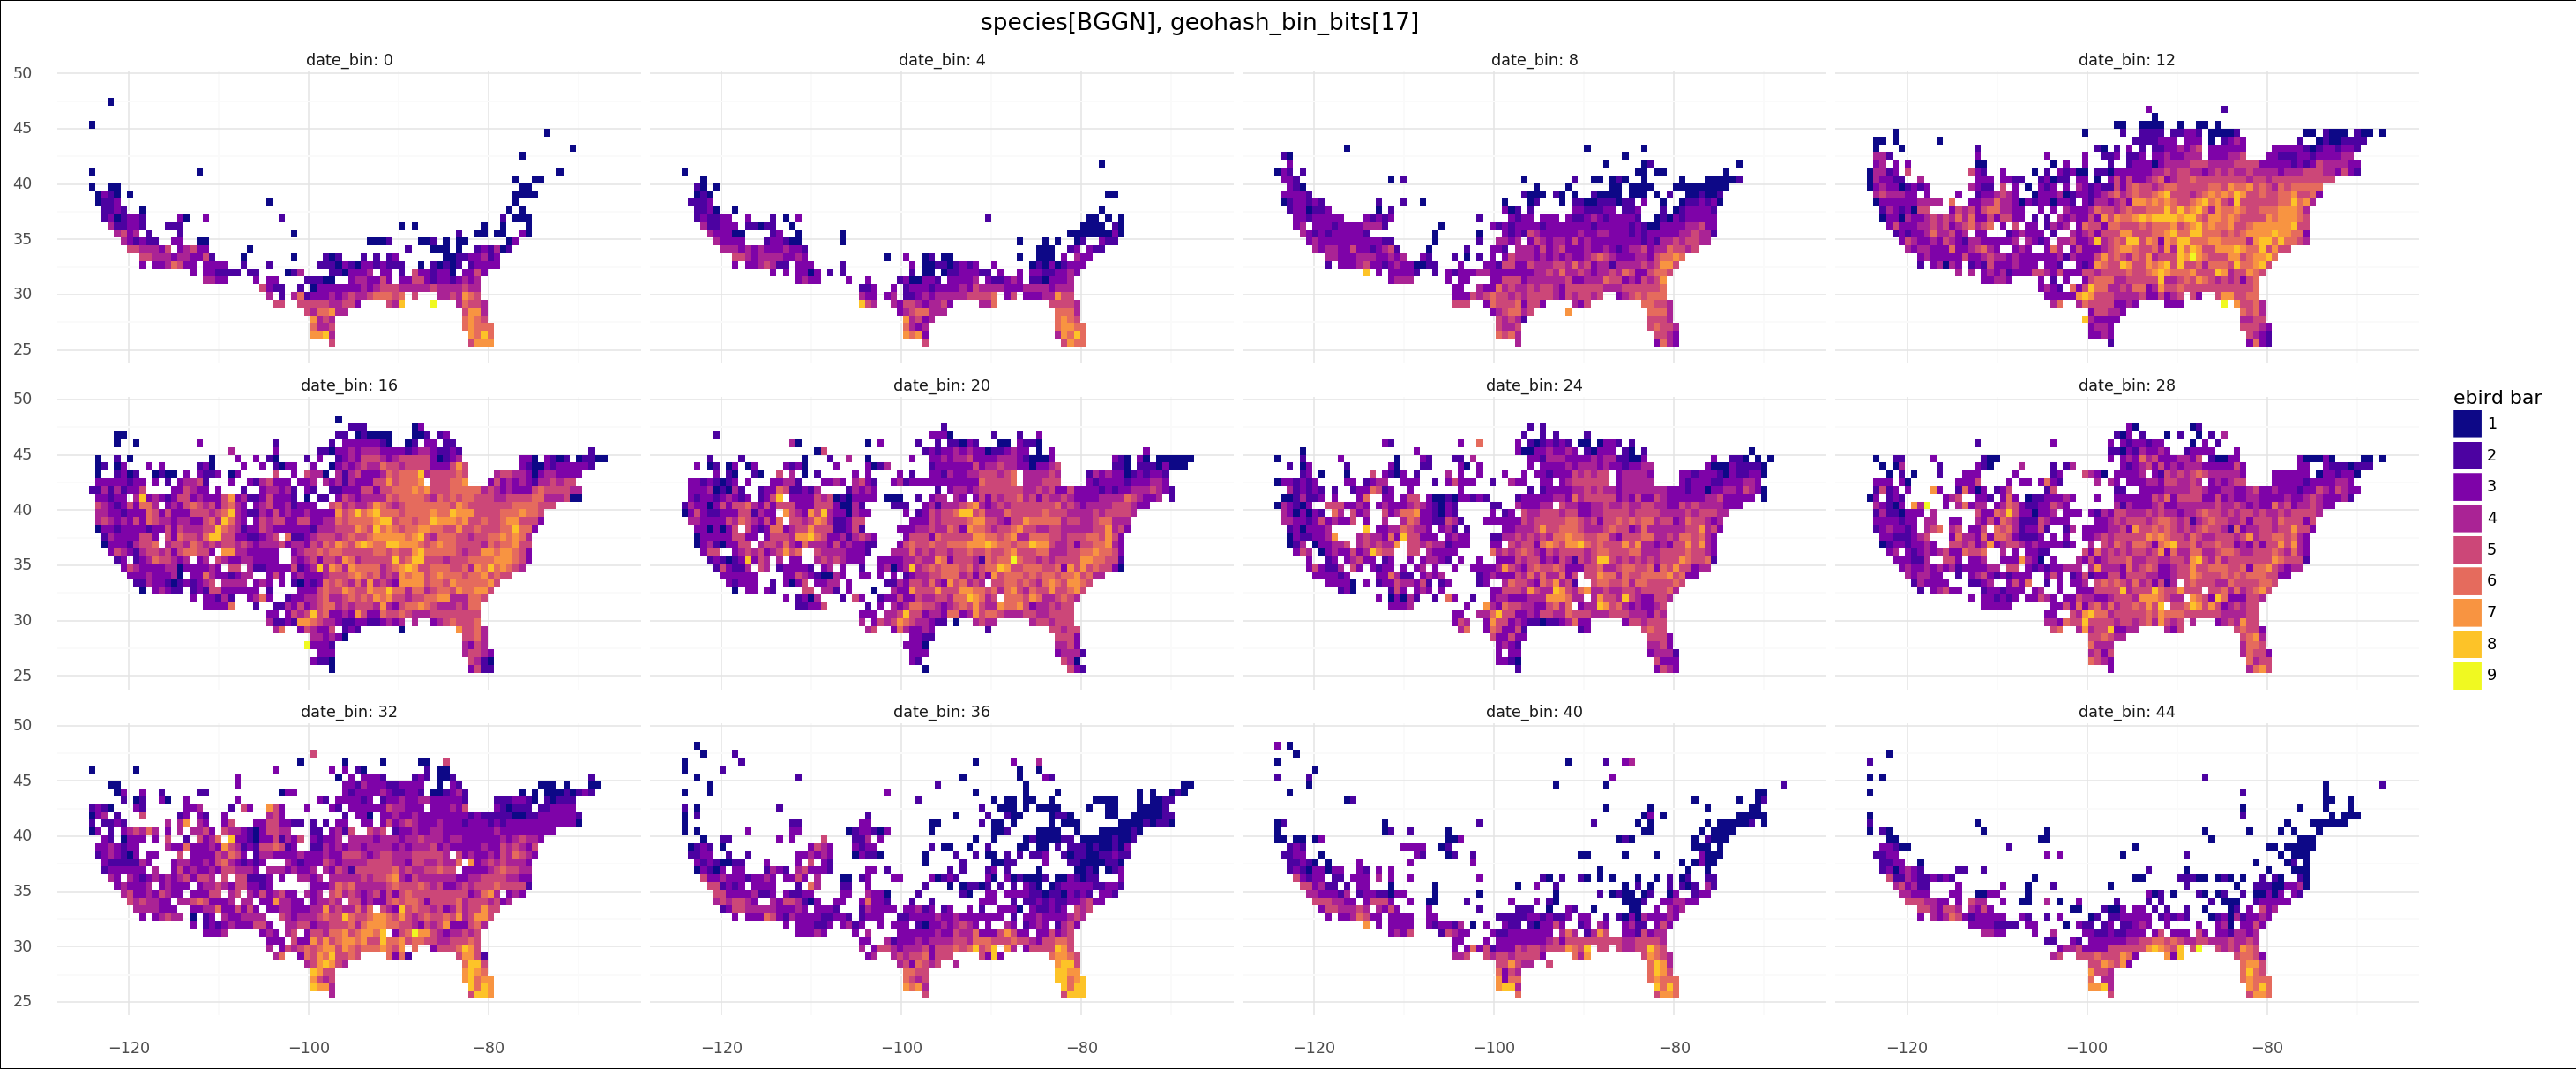

<ggplot: (322468349)>

In [ ]:
# Plot
ebird_priors = EbirdPriors(
    loc_binwidth  = first(k for k, v in EbirdPriors._loc_binwidths.items() if v == geohash_bin_bits),
    date_binwidth = first(k for k in EbirdPriors._date_binwidths if k == '%sw' % date_bin_weeks),
)
(df
    # [:100]  # XXX Dev
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:5])
    .assign(
        w=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['w'])(df.geohash_bin),
        e=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['e'])(df.geohash_bin),
        s=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['s'])(df.geohash_bin),
        n=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['n'])(df.geohash_bin),
    )
    .assign(**{
        # Adjust lon wrapping (in [-180,180])
        k: lambda df, k=k: (df[k] + 270) % 360 - 270
        for k in ['w', 'e']
    })
    .pipe(ggplot)
    + facet_wrap('date_bin', labeller='label_both')
    + aes(xmin='w', xmax='e', ymin='s', ymax='n')
    + aes(fill='factor(bin_p_sp_bar_width)') + scale_fill_cmap_d('plasma', limits=range(1, 9+1))
    + geom_bin2d(stat='identity')
    + lims(x=[-125, -66], y=[25, 49])  # ~US
    + labs(fill='ebird bar')
    + theme_minimal()
    + theme_figsize(aspect=1/2, width=24)
    + ggtitle('species[%(species)s], geohash_bin_bits[%(geohash_bin_bits)s]' % locals())
)

# TODO TODO YOU ARE HERE
- In the middle of rolling out the new structured bqq.query(...) api, to replace the old bqq('...') api
    - Done above ^, TODO below v
- Then, back to debugging smoothing
    - Still (maybe) some bugs to debug, where neighboring geo bins don't look right wrt. subbins (using BGGN plots below)

In [ ]:
# WARNING ~$0.20
# Make priors table
#   - See ebird_priors.py for bits:mi mapping (EbirdPriors._loc_binwidths)
# Stats: all countries
#   - geo[12mi] date[1w] country[*]:  115s,  74m rows, 3.36gb
#   - geo[48mi] date[2w] country[*]:   92s,  29m rows, 1.29gb
# Stats: US
#   - geo[21b,12mi] date[1w] country[US]:  85s,  39m rows -- export fails b/c >1gb; could fix with wildcard but sqlite would be too big anyway
#   - geo[21b,12mi] date[2w] country[US]:  64s,  27m rows, bq[937mb,  37s] fetch[181s] df[3.6gb] sqlite[637mb, 147s]
#   - geo[19b,24mi] date[2w] country[US]:  42s,  18m rows, bq[606mb,  35s] fetch[117s] df[2.4gb] sqlite[412mb,  89s]
#   - geo[17b,48mi] date[2w] country[US]:  46s,  13m rows, bq[433mb,  34s] fetch[ 82s] df[1.7gb] sqlite[300mb,  69s]
#   - geo[21b,12mi] date[4w] country[US]:  65s,  18m rows, bq[629mb,  38s] fetch[118s] df[2.4gb] sqlite[429mb,  98s]
#   - geo[19b,24mi] date[4w] country[US]:  44s,  11m rows, bq[392mb,  29s] fetch[ 77s] df[1.6gb] sqlite[267mb,  64s]
#   - geo[17b,48mi] date[4w] country[US]: 106s, 7.9m rows, bq[272mb,  36s] fetch[ 57s] df[1.1gb] sqlite[189mb,  51s]
date_bin_weeks = (
    4  # 4w
)
geohash_bin_bits = (
    17  # 48mi
)
geohash_subbin_bits = geohash_bin_bits + 2
table = (
    # 'ebird.obs_sample_001'     # XXX Dev
    'ebird.obs_all_expensive'  # WARNING
)
smooth_scale = (
    1/2  # 2x = smooth geohash[b] via geohash[b+2].expands (2x) + no date smoothing (1x)
)
hll_precision = (
    # https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#hyperloglog-functions
    10  # time:smooth[TODO] time:exact[TODO] -- XXX Dev
    # 15  # time:smooth[TODO] time:exact[17s] -- Some small errors vs. exact (for BGGN)
    # 18  # time:smooth[764s] time:exact[18s] -- No visible error vs. exact exact (for BGGN)
    # 24  # time:smooth[518s] time:exact[17s] -- Max precision, doesn't blow up mem and no slower than the others, so let's go with it
)
a_or_b = (
    'a' # XXX Dev: exact
    # 'b' # smooth
)
priors_df = (bqq('''
    with

        -- Base data
        a as (
            select
                mul_trunc(ebird_week(observation_date), %(date_bin_weeks)s)                 as date_bin,
                geohash_at_bits(st_geogpoint(longitude, latitude), %(geohash_bin_bits)s)    as geohash_bin,
                geohash_at_bits(st_geogpoint(longitude, latitude), %(geohash_subbin_bits)s) as geohash_subbin,
                ifnull(s.shorthand, '_UNK')                                                 as species,
                # sampling_event_identifier                                                   as checklist_id
                hll_count.init(sampling_event_identifier, %(hll_precision)s)                as subbin_hll_checklists
            from %(table)s e
                left join metadata.species s on (s.com_name = e.common_name)
            where true
                and category in ('species', 'issf', 'form', 'intergrade')
                and country_code = 'US'
                # and state_code = 'US-CA'            # XXX Dev
                # and county_code = 'US-CA-075'       # XXX Dev (SF) -- XXX Not a good geo filter, very noisy!
                # and longitude between -122.6 and -122.3 and latitude between 37.66 and 37.82 # XXX Dev (SF)
            # group by 1,2,3,4,5 # For checklist_id
            group by 1,2,3,4   # For subbin_hll_checklists
        ),

        -- Expand by geo
        b as (
            # select distinct -- De-dupe cycles in expands # XXX Nope, slower: ~141s i/o 63s
            select
                a1.date_bin,
                a1.geohash_bin,
                a1.geohash_subbin,
                a2.geohash_subbin as geohash_subbin_expand,
                a2.species,
                # a2.checklist_id
                a2.subbin_hll_checklists
            from (
                select
                    date_bin,
                    geohash_bin,
                    geohash_subbin
                from a
            ) a1
                join geoh.all_geohashes_with_expand_precision_bits_%(geohash_subbin_bits)s expand on true
                    and a1.geohash_subbin = expand.x
                join a a2 on true
                    and a1.date_bin = a2.date_bin
                    and expand.y = a2.geohash_subbin
        ),

        a_or_b as (
            select * from %(a_or_b)s
        ),

        -- Smooth across expanded geo
        --  - Using group-by-and-join i/o a single windowed query b/c the latter failed on resources and the former doesn't
        --  - And hll_count.merge isn't supported in analytic queries (ugh), so we have to group-by-and-join to use that
        c1 as (
            select
                date_bin,
                geohash_bin,
                species,
                # %(smooth_scale)s * count(distinct checklist_id) as bin_n_checklists_with_sp
                %(smooth_scale)s * hll_count.merge(subbin_hll_checklists) as bin_n_checklists_with_sp
            from a_or_b
            group by 1,2,3
        ),
        c2 as (
            select
                date_bin,
                geohash_bin,
                # %(smooth_scale)s * count(distinct checklist_id) as bin_n_checklists
                %(smooth_scale)s * hll_count.merge(subbin_hll_checklists) as bin_n_checklists
            from a_or_b
            group by 1,2
        ),
        c as (
            select
                c1.*,
                c2.bin_n_checklists
            from c1 join c2 using (
                date_bin,
                geohash_bin
            )
        )

    # # TODO TODO Restore (for payload)
    # select *
    # from c

    # XXX Dev: QA
    select
        *,
        ebird_bar_str(bin_n_checklists_with_sp / bin_n_checklists)   as bin_p_sp_bar_str,
        ebird_bar_width(bin_n_checklists_with_sp / bin_n_checklists) as bin_p_sp_bar_width,
        bin_n_checklists_with_sp / bin_n_checklists                  as bin_p_sp
    from c
    where true
        and species = 'BGGN'
    order by date_bin, geohash_bin desc, bin_p_sp desc

''' % locals(),
    # max_rows=50,  # XXX
    max_rows=None,  # WARNING Big fetch
)
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: humanize.naturalsize_binary(df.memory_usage(deep=True).sum()))
    .pipe(df_inspect, lambda df: df[:50]
        .pipe(lambda df: df if 'bin_p_sp' not in df.columns else df
            .pipe(df_col_map, bin_p_sp=lambda x: '%.3f' % x)
        )
    )
)

Running query...

[762s] cost[$0.1513, 33.3 GB] rows[13999] size[1.1 MiB] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_04NKMpjAeb3PCUR3Vug_UQJTDriL&page=queryresults]

Fetching results...

[2s]

(13999, 8)

3.5 MiB

,date_bin,geohash_bin,species,bin_n_checklists_with_sp,bin_n_checklists,bin_p_sp_bar_str,bin_p_sp_bar_width,bin_p_sp
0,0,f2h0,BGGN,0.5,1410.0,■————————,1,0.000
1,0,druh,BGGN,0.5,10400.0,■————————,1,0.000
2,0,drts,BGGN,0.5,26600.0,■————————,1,0.000
3,0,drth,BGGN,0.5,19700.0,■————————,1,0.000
4,0,drt8,BGGN,0.5,37000.0,■————————,1,0.000
5,0,drt0,BGGN,0.5,36300.0,■————————,1,0.000
6,0,drm0,BGGN,0.5,9610.0,■————————,1,0.000
7,0,drks,BGGN,0.5,21700.0,■————————,1,0.000
8,0,drkh,BGGN,0.5,25300.0,■————————,1,0.000
9,0,drk8,BGGN,1.0,15800.0,■————————,1,0.000


(13999, 8)

(13999, 8)

,date_bin,geohash_bin,species,bin_n_checklists_with_sp,bin_n_checklists,bin_p_sp_bar_str,bin_p_sp_bar_width,bin_p_sp
0,0,f2h0,BGGN,0.5,1410.0,■————————,1,3.540e-04
1,0,druh,BGGN,0.5,10400.0,■————————,1,4.830e-05
2,0,drts,BGGN,0.5,26600.0,■————————,1,1.880e-05
3,0,drth,BGGN,0.5,19700.0,■————————,1,2.540e-05
4,0,drt8,BGGN,0.5,37000.0,■————————,1,1.350e-05


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:453: PlotnineWarning: geom_bin2d : Removed 120 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


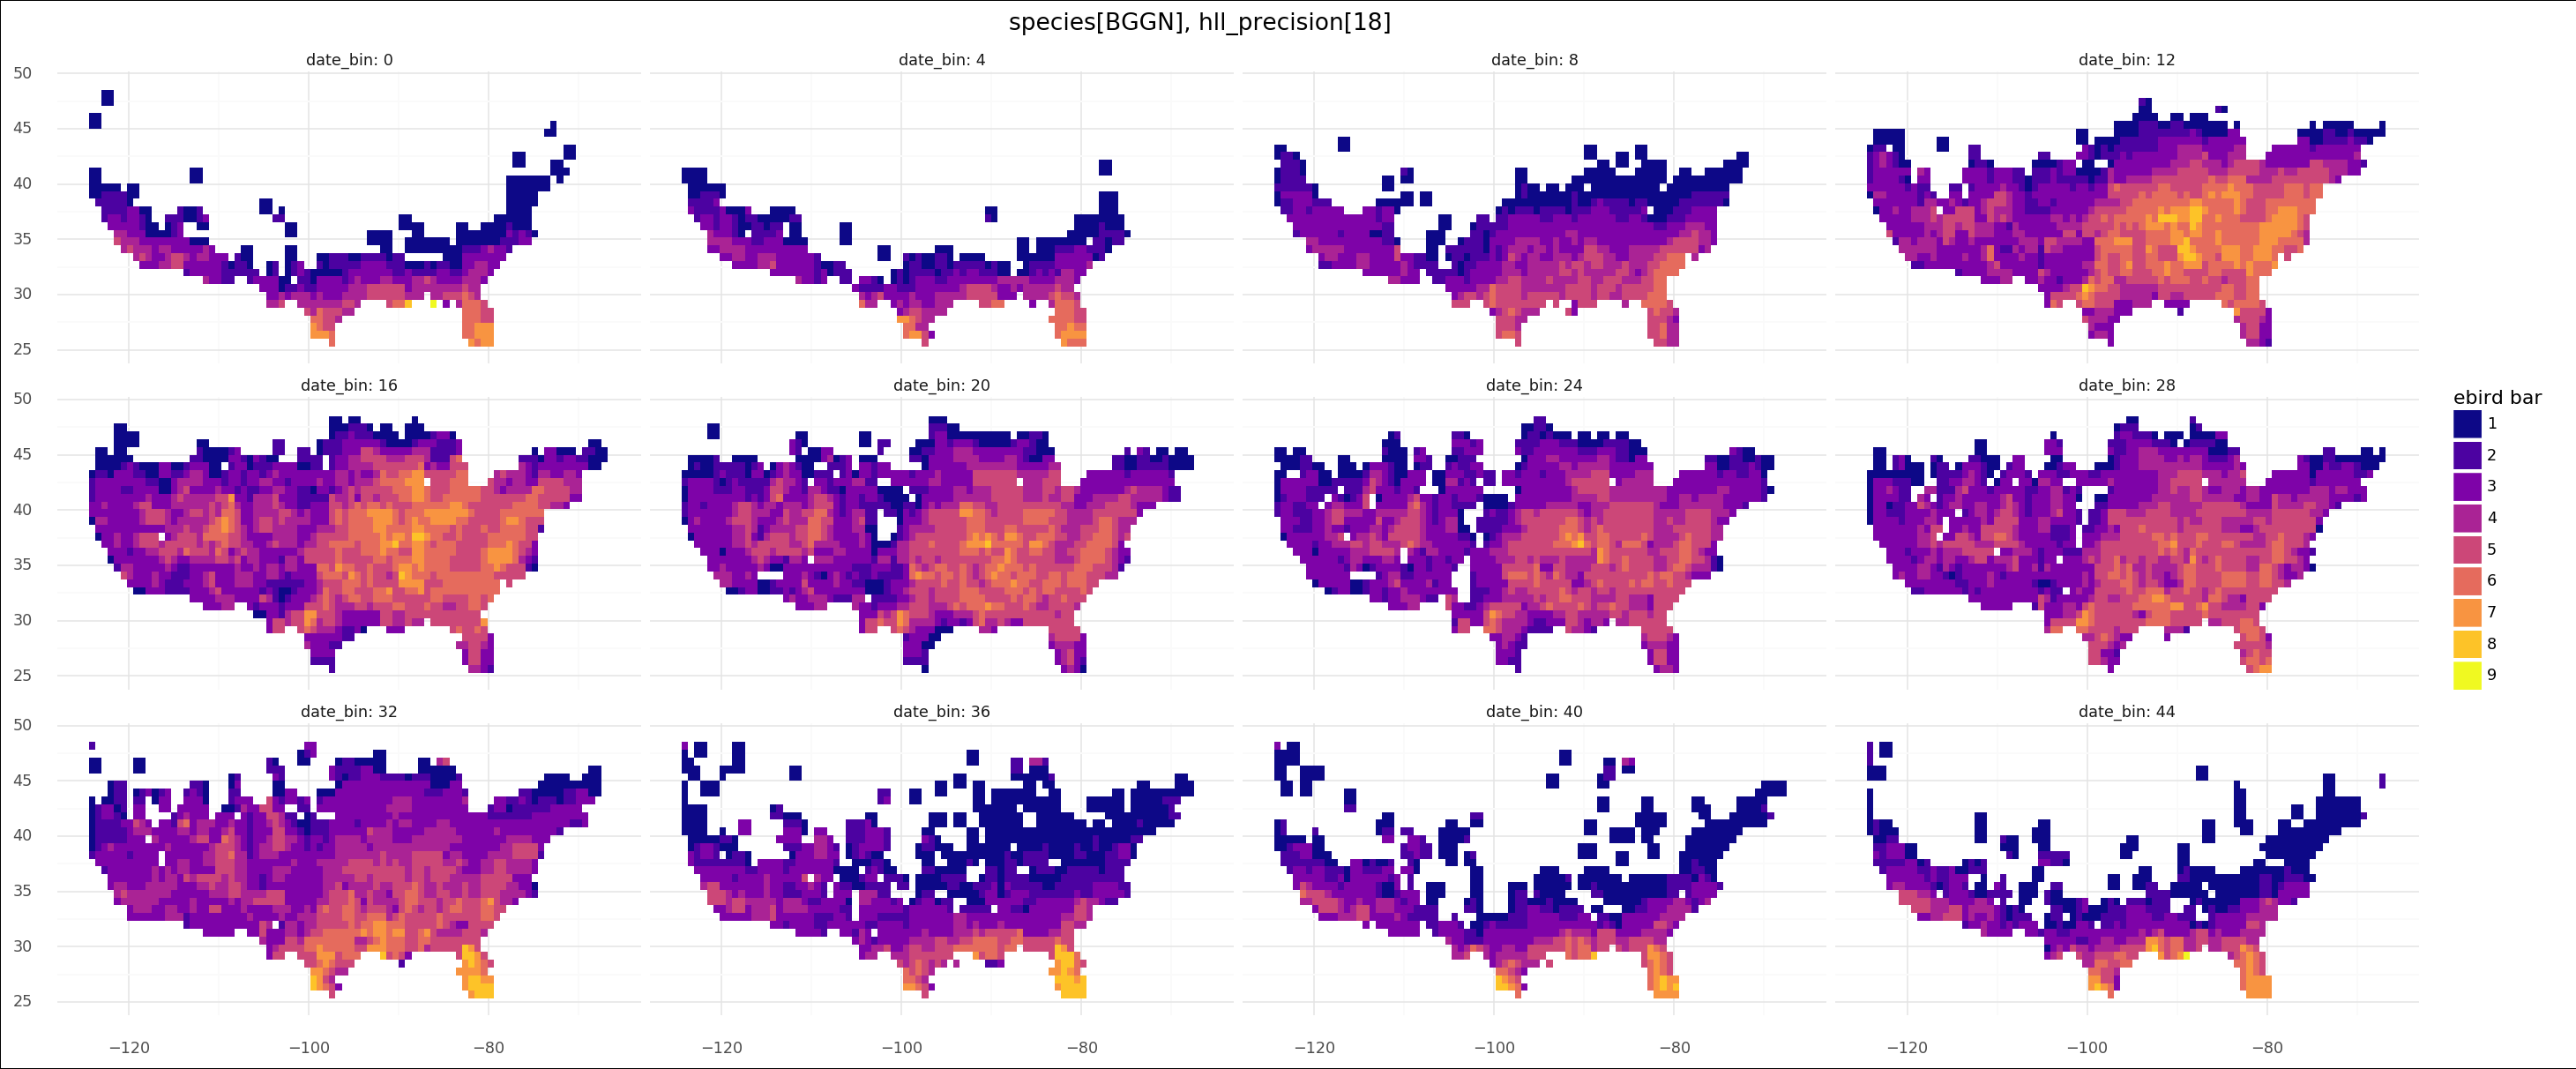

<ggplot: (-9223372036520090606)>

In [ ]:
# Inspect for one species
species = 'BGGN'
ebird_priors = EbirdPriors(
    loc_binwidth  = first(k for k, v in EbirdPriors._loc_binwidths.items() if v == geohash_bin_bits),
    date_binwidth = first(k for k in EbirdPriors._date_binwidths if k == '%sw' % date_bin_weeks),
)
(priors_df
    # [:100]  # XXX Dev
    .pipe(df_inspect, lambda df: (df.shape,))
    [lambda df: df.species == species]
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:5])
    .assign(
        w=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['w'])(df.geohash_bin),
        e=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['e'])(df.geohash_bin),
        s=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['s'])(df.geohash_bin),
        n=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['n'])(df.geohash_bin),
    )
    .assign(**{
        # Adjust lon wrapping (in [-180,180])
        k: lambda df, k=k: (df[k] + 270) % 360 - 270
        for k in ['w', 'e']
    })
    .pipe(ggplot)
    + facet_wrap('date_bin', labeller='label_both')
    + aes(xmin='w', xmax='e', ymin='s', ymax='n')
    + aes(fill='factor(bin_p_sp_bar_width)') + scale_fill_cmap_d('plasma', limits=range(1, 9+1))
    + geom_bin2d(stat='identity')
    + lims(x=[-125, -66], y=[25, 49])  # ~US
    + labs(fill='ebird bar')
    + theme_minimal()
    + theme_figsize(aspect=1/2, width=24)
    + ggtitle('species[%(species)s], hll_precision[%(hll_precision)s]' % locals())
)

# TODO TODO Composable bq

In [ ]:
# Params
date_bin_weeks = (
    4  # 4w
)
geohash_bin_bits = (
    17  # 48mi
)
geohash_subbin_bits = geohash_bin_bits + 2
table = (
    'ebird.obs_sample_001'     # XXX Dev
    # 'ebird.obs_all_expensive'  # WARNING
)
smooth_scale = (
    1/2  # 2x = smooth geohash[b] via geohash[b+2].expands (2x) + no date smoothing (1x)
)
hll_precision = (
    # https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#hyperloglog-functions
    10  # time:smooth[TODO] time:exact[TODO] -- XXX Dev
    # 15  # time:smooth[TODO] time:exact[17s] -- Some small errors vs. exact (for BGGN)
    # 18  # time:smooth[764s] time:exact[18s] -- No visible error vs. exact exact (for BGGN)
    # 24  # time:smooth[518s] time:exact[17s] -- Max precision, doesn't blow up mem and no slower than the others, so let's go with it
)
smooth = (
    False  # XXX Dev: exact
    # True
)

In [ ]:
# Base data
a = (bqq
    .from_(f"{table} e left join metadata.species s on (s.com_name = e.common_name)")
    .where(f'''true
        and category in ('species', 'issf', 'form', 'intergrade')
        and country_code = 'US'
        # and state_code = 'US-CA'            # XXX Dev
        # and county_code = 'US-CA-075'       # XXX Dev (SF) -- XXX Not a good geo filter, very noisy!
        # and longitude between -122.6 and -122.3 and latitude between 37.66 and 37.82 # XXX Dev (SF)
    ''')
    # .group_by('1,2,3,4,5') # For checklist_id
    .group_by('1,2,3,4')   # For subbin_hll_checklists
    .select(f'''
        mul_trunc(ebird_week(observation_date), {date_bin_weeks})                 as date_bin,
        geohash_at_bits(st_geogpoint(longitude, latitude), {geohash_bin_bits})    as geohash_bin,
        geohash_at_bits(st_geogpoint(longitude, latitude), {geohash_subbin_bits}) as geohash_subbin,
        ifnull(s.shorthand, '_UNK')                                               as species,
        # sampling_event_identifier                                                 as checklist_id,
        hll_count.init(sampling_event_identifier, {hll_precision})                as subbin_hll_checklists,
    ''')
    .inspect(lambda t: t.limit(10).df())
)

INFO     [16:36:22.249] [56195] 255 potoo.bqq/_bqq: Running query...

INFO     [16:36:27.430] [56195] 270 potoo.bqq/_bqq: [5s] cost[$0.0002, 33.6 MB] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_RJgNA_HSJ-FOGCeZos10pEEmLQS2&page=queryresults]

INFO     [16:36:27.449] [56195] 286 potoo.bqq/_bqq: Fetching results...

INFO     [16:36:28.074] [56195] 320 potoo.bqq/_bqq: [1s]

,date_bin,geohash_bin,geohash_subbin,species,subbin_hll_checklists
0,24,bfr8,bfrd,BAEA,CHAQARgCIAuCBwsQARgKIA8yA7PwAQ==
1,20,djeh,djen,BRTH,CHAQARgCIAuCBwsQARgKIA8yA+67AQ==
2,20,djfs,djfu,CARW,CHAQARgCIAuCBwsQARgKIA8yA7PgAQ==
3,20,9yk8,9ykb,BLJA,CHAQAxgCIAuCBw0QAxgKIA8yBeRRpz0M
4,12,9yk8,9ykb,RBWO,CHAQAhgCIAuCBw0QAhgKIA8yBahC9pEB
5,36,9yq0,9yq4,BEKI,CHAQAhgCIAuCBw0QAhgKIA8yBZW+AZE9
6,16,9t98,9t9d,WAVI,CHAQAxgCIAuCBw8QAxgKIA8yB4aPAZEN92A=
7,40,9t98,9t9d,WEME,CHAQARgCIAuCBwsQARgKIA8yA57kAQ==
8,16,9t98,9t9d,CACW,CHAQAhgCIAuCBwwQAhgKIA8yBLV3wls=
9,16,9t98,9t9d,CRTH,CHAQARgCIAuCBwsQARgKIA8yA7+9AQ==


In [ ]:
# Expand by geo
b = (bqq
    .with_(a=a)
    .from_(f'''
        (
            select
                date_bin,
                geohash_bin,
                geohash_subbin
            from a
        ) a1
        join geoh.all_geohashes_with_expand_precision_bits_{geohash_subbin_bits} expand on true
            and a1.geohash_subbin = expand.x
        join a a2 on true
            and a1.date_bin = a2.date_bin
            and expand.y = a2.geohash_subbin
    ''')
    .select(f'''
        # distinct -- De-dupe cycles in expands # XXX Nope, slower: ~141s i/o 63s
        a1.date_bin,
        a1.geohash_bin,
        a1.geohash_subbin,
        a2.geohash_subbin as geohash_subbin_expand,
        a2.species,
        # a2.checklist_id,
        a2.subbin_hll_checklists,
    ''')
    .inspect(lambda t: t.limit(10).df())
)

INFO     [16:36:33.401] [56195] 255 potoo.bqq/_bqq: Running query...

INFO     [16:36:41.149] [56195] 270 potoo.bqq/_bqq: [8s] cost[$0.0004, 90.1 MB] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_dV1spAvzw9wpz5NvP1vzmnX3BU-n&page=queryresults]

INFO     [16:36:41.165] [56195] 286 potoo.bqq/_bqq: Fetching results...

INFO     [16:36:41.795] [56195] 320 potoo.bqq/_bqq: [1s]

,date_bin,geohash_bin,geohash_subbin,geohash_subbin_expand,species,subbin_hll_checklists
0,36,87ph,87ph,87ph,WTSH,CHAQARgCIAuCBwsQARgKIA8yA8HIBw==
1,28,8e30,8e36,8e36,BTCU,CHAQARgCIAuCBwsQARgKIA8yA721AQ==
2,28,8e30,8e36,8e3k,HOSP,CHAQARgCIAuCBwoQARgKIA8yArxg
3,28,8e30,8e36,8e3k,WATA,CHAQARgCIAuCBwoQARgKIA8yAvwO
4,32,87rh,87rk,87rk,NESH,CHAQARgCIAuCBwsQARgKIA8yA5WTAQ==
5,24,8e3h,8e3h,8e3h,APAP,CHAQAhgCIAuCBwwQAhgKIA8yBPQW21U=
6,24,8e3h,8e3h,8e3h,HAEL,CHAQARgCIAuCBwoQARgKIA8yAvVe
7,16,8e3h,8e3h,8e3h,APAP,CHAQARgCIAuCBwsQARgKIA8yA8fsAQ==
8,4,8e3h,8e3h,8e3h,JAWE,CHAQARgCIAuCBwsQARgKIA8yA//9AQ==
9,4,8e3h,8e3h,8e3h,SPDO,CHAQARgCIAuCBwoQARgKIA8yAo9t


In [ ]:
# Smooth across expanded geo
#   - Using group-by-and-join i/o a single windowed query b/c the latter failed on resources and the former doesn't
#   - And hll_count.merge isn't supported in analytic queries (ugh), so we have to group-by-and-join to use that
c = (bqq
    .with_(
        a_or_b=b if smooth else a,
        c1=(bqq
            .from_('a_or_b')
            .group_by('1,2,3')
            .select(f'''
                date_bin,
                geohash_bin,
                species,
                # {smooth_scale} * count(distinct checklist_id) as bin_n_checklists_with_sp,
                {smooth_scale} * hll_count.merge(subbin_hll_checklists) as bin_n_checklists_with_sp,
            ''')
        ),
        c2=(bqq
            .from_('a_or_b')
            .group_by('1,2')
            .select(f'''
                date_bin,
                geohash_bin,
                # {smooth_scale} * count(distinct checklist_id) as bin_n_checklists,
                {smooth_scale} * hll_count.merge(subbin_hll_checklists) as bin_n_checklists,
            ''')
        ),
    )
    .from_(f'''
        c1 join c2 using (
            date_bin,
            geohash_bin
        )
    ''')
    .select(f'''
        c1.*,
        c2.bin_n_checklists,
    ''')
    .inspect(lambda t: t.limit(10).df())
)

INFO     [16:36:41.995] [56195] 255 potoo.bqq/_bqq: Running query...

INFO     [16:36:51.290] [56195] 270 potoo.bqq/_bqq: [9s] cost[$0.0002, 33.6 MB] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_UFWKi1oMrjwa1eWYmIc5Z5SxrcsL&page=queryresults]

INFO     [16:36:51.308] [56195] 286 potoo.bqq/_bqq: Fetching results...

INFO     [16:36:51.559] [56195] 320 potoo.bqq/_bqq: [0s]

,date_bin,geohash_bin,species,bin_n_checklists_with_sp,bin_n_checklists
0,24,bfr8,BAEA,0.5,2.0
1,20,djeh,BRTH,0.5,6.0
2,20,djfs,CARW,0.5,7.0
3,20,9yk8,BLJA,1.5,10.5
4,12,9yk8,RBWO,1.0,16.5
5,36,9yq0,BEKI,1.0,1.5
6,16,9t98,WAVI,1.5,82.5
7,40,9t98,WEME,0.5,10.5
8,16,9t98,CACW,1.0,82.5
9,16,9t98,CRTH,0.5,82.5


In [ ]:
# Inspect
(c
    .nest()
    .where(f'''true
        and species = 'BGGN'
    ''')
    .select(f'''
        *,
        ebird_bar_str(bin_n_checklists_with_sp / bin_n_checklists)   as bin_p_sp_bar_str,
        ebird_bar_width(bin_n_checklists_with_sp / bin_n_checklists) as bin_p_sp_bar_width,
        bin_n_checklists_with_sp / bin_n_checklists                  as bin_p_sp,
    ''')
    .order_by('date_bin, geohash_bin desc, bin_p_sp desc')
    .df()
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: humanize.naturalsize_binary(df.memory_usage(deep=True).sum()))
    .pipe(df_inspect, lambda df: df[:50]
        .pipe(lambda df: df if 'bin_p_sp' not in df.columns else df
            .pipe(df_col_map, bin_p_sp=lambda x: '%.3f' % x)
        )
    )
    .shape
)

INFO     [16:36:51.769] [56195] 255 potoo.bqq/_bqq: Running query...

INFO     [16:36:59.754] [56195] 270 potoo.bqq/_bqq: [8s] cost[$0.0002, 33.6 MB] rows[1041] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job__zyvoggEN2pCB_pehlTsLDCP4ARU&page=queryresults]

INFO     [16:36:59.766] [56195] 286 potoo.bqq/_bqq: Fetching results...

INFO     [16:37:00.410] [56195] 320 potoo.bqq/_bqq: [1s]

(1000, 8)

255.9 KiB

,date_bin,geohash_bin,species,bin_n_checklists_with_sp,bin_n_checklists,bin_p_sp_bar_str,bin_p_sp_bar_width,bin_p_sp
0,0,djw0,BGGN,0.5,34.0,■■■——————,3,0.015
1,0,djnh,BGGN,0.5,28.0,■■■——————,3,0.018
2,0,djn8,BGGN,0.5,140.0,■■———————,2,0.004
3,0,djn0,BGGN,1.5,98.5,■■■——————,3,0.015
4,0,djms,BGGN,0.5,14.5,■■■——————,3,0.034
5,0,djm0,BGGN,3.0,62.0,■■■——————,3,0.048
6,0,djk0,BGGN,1.5,48.0,■■■——————,3,0.031
7,0,djjs,BGGN,0.5,11.5,■■■——————,3,0.043
8,0,djjh,BGGN,0.5,14.0,■■■——————,3,0.036
9,0,djj8,BGGN,0.5,42.0,■■■——————,3,0.012


(1000, 8)

In [ ]:
# For .sqlite payload
priors_df = (c
    .limit(50)  # XXX Dev
    .df(max_rows=None)  # i/o default max_rows=1000
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:10])
)

INFO     [16:37:00.661] [56195] 255 potoo.bqq/_bqq: Running query...

INFO     [16:37:09.087] [56195] 270 potoo.bqq/_bqq: [8s] cost[$0.0002, 33.6 MB] rows[50] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_5kaZSrKnRPpiOwquGTYMQzIDzjOw&page=queryresults]

INFO     [16:37:09.097] [56195] 286 potoo.bqq/_bqq: Fetching results...

INFO     [16:37:09.450] [56195] 320 potoo.bqq/_bqq: [0s]

(50, 5)

,date_bin,geohash_bin,species,bin_n_checklists_with_sp,bin_n_checklists
0,24,bfr8,BAEA,0.5,2.0
1,20,djeh,BRTH,0.5,6.0
2,20,djfs,CARW,0.5,7.0
3,20,9yk8,BLJA,1.5,10.5
4,12,9yk8,RBWO,1.0,16.5
5,36,9yq0,BEKI,1.0,1.5
6,16,9t98,WAVI,1.5,82.5
7,40,9t98,WEME,0.5,10.5
8,16,9t98,CACW,1.0,82.5
9,16,9t98,CRTH,0.5,82.5


# TODO Re-join sqlite write step with sql read step above

In [ ]:
# Write .sqlite

# TODO -> mobile payload (cf. payloads.py)
db_path = Path('~/tmp').expanduser() / ('priors-%s.sqlite3' % re.sub(r'[^0-9T]', '-', datetime.utcnow().isoformat()))

with sqla_oneshot_eng_conn_tx(f'sqlite:///{ensure_parent_dir(db_path)}') as conn:
    table = 'priors'
    def size_sql_relation(name: str) -> int:
        df = pd.read_sql(con=conn, sql='''
            select sum(pgsize) as size from dbstat where name=:name
        ''', params=dict(
            name=name,
        ))
        return one(df_rows(df))['size']  # (Careful: df['size'] i/o df.size, else you'll get the row count)
    with log_time_context(f'Mobile: Create table {table}', lambda: humanize.naturalsize_binary(size_sql_relation(table) or 0)):
        (priors_df
            .pipe(df_inspect, lambda df: (df.shape,))
            .pipe(df_inspect, lambda df: humanize.naturalsize_binary(df.memory_usage(deep=True).sum()))
            .pipe(df_inspect, lambda df: df[:10])
            .to_sql(table, conn,
                if_exists='replace',
                index=False,  # Silently drop df index (we shouldn't have any)
                chunksize=1000,  # Safe default for big writes (pd default writes all rows at once -- mem unsafe)
            )
        )

!ls -sh {db_path}

# TODO Smoothing for geohash stuff

In [ ]:
# XXX
df_rel = (
    pd.DataFrame(columns=['x', 'y'], data=(
        (x, y)
        for x in df_base.geohash_bin
        for y in geoh.str_expand(x, 21)  # str_expand i/o str_neighbors so we include (x, x) in relation
    ))
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:10])
)

(1316175, 2)

,x,y
0,sxk9h,sxk80
1,sxk9h,sxk8h
2,sxk9h,sxk90
3,sxk9h,sxk9h
4,sxk9h,sxkb0
5,sxk9h,sxkc0
6,sxk9h,sxkd0
7,sxk9h,sxkdh
8,sxk9h,sxkf0
9,w60u0,w60eh
